In [22]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from modem import qpsk, chirp, wav, pilot
from modem.constants import FS, QPSK_BLOCK_LENGTH, BYTES_BLOCK_LENGTH, DATA_PER_PILOT, OFDM_SYMBOL_LENGTH

In [23]:
#TODO: Use an actual file here
TRANSMITTED_DATA_BLOCKS = 10
rng = np.random.default_rng(seed=42)
data_bytes = [bytes(rng.integers(256, size=BYTES_BLOCK_LENGTH, dtype=np.uint8)) for i in range(TRANSMITTED_DATA_BLOCKS)]
data_qpsk_symbols = [qpsk.qpsk_encode(data) for data in data_bytes]
data_ofdm_symbols = [qpsk.encode_ofdm_symbol(qpsk_syms) for qpsk_syms in data_qpsk_symbols]

In [25]:
PILOT_BLOCKS = 1+(TRANSMITTED_DATA_BLOCKS//DATA_PER_PILOT)
rng = np.random.default_rng(seed=42)
pilot_bytes = [bytes(rng.integers(256, size=BYTES_BLOCK_LENGTH, dtype=np.uint8)) for i in range(PILOT_BLOCKS)]
pilot_qpsk_symbols = [qpsk.qpsk_encode(data) for data in pilot_bytes]
pilot_ofdm_symbols = [qpsk.encode_ofdm_symbol(qpsk_syms) for qpsk_syms in pilot_qpsk_symbols]

ofdm_symbols = pilot.interleave_pilot_blocks(data_ofdm_symbols,pilot_ofdm_symbols)
signal = np.concatenate((chirp.START_CHIRP, *ofdm_symbols, chirp.END_CHIRP))
signal = signal.astype(np.float32)

In [ ]:
wav.generate_wav("pilots.wav", signal)

Saved to C:\Users\dcies\Desktop\Audio Modem\audio_modem_2025\src\modem\..\..\files\pilots.wav


In [46]:
wav.record_wav("2025-05-28_LT5.wav", 15)

Recording for 15 seconds at 48000 Hz...
Saved to C:\Users\dcies\Desktop\Audio Modem\audio_modem_2025\src\modem\..\..\files\2025-05-28_LT5.wav


In [29]:
recv_signal = wav.read_wav("2025-05-28_H06.wav")

start_lag = np.int64(95599), end_lag = np.int64(359295), difference = np.int64(263696), expected_difference = 263040


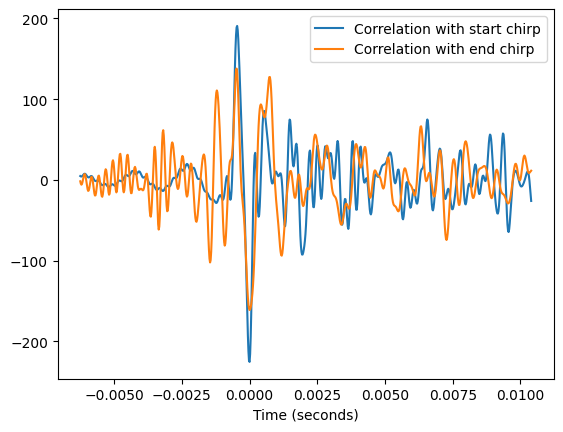

In [36]:
#TODO: Dont assume known length of stuff, repeated synchronisation etc
aligned_recv_signal = chirp.synchronise(recv_signal, sum(map(len, ofdm_symbols)), plot_correlations=True)
RECIEVED_BLOCKS = int(len(aligned_recv_signal[chirp.START_CHIRP.size:-chirp.END_CHIRP.size])/OFDM_SYMBOL_LENGTH)
recv_ofdm_symbols = np.split(aligned_recv_signal[chirp.START_CHIRP.size:-chirp.END_CHIRP.size], RECIEVED_BLOCKS)

In [37]:
RECIEVED_PILOT_BLOCKS = int(1+((RECIEVED_BLOCKS-1)//(1+DATA_PER_PILOT)))
RECIEVED_DATA_BLOCKS = RECIEVED_BLOCKS - RECIEVED_PILOT_BLOCKS

C:\Users\dcies\AppData\Local\Temp\ipykernel_13768\1298182359.py:7: RuntimeWarning: divide by zero encountered in log10
  pcm = ax.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')


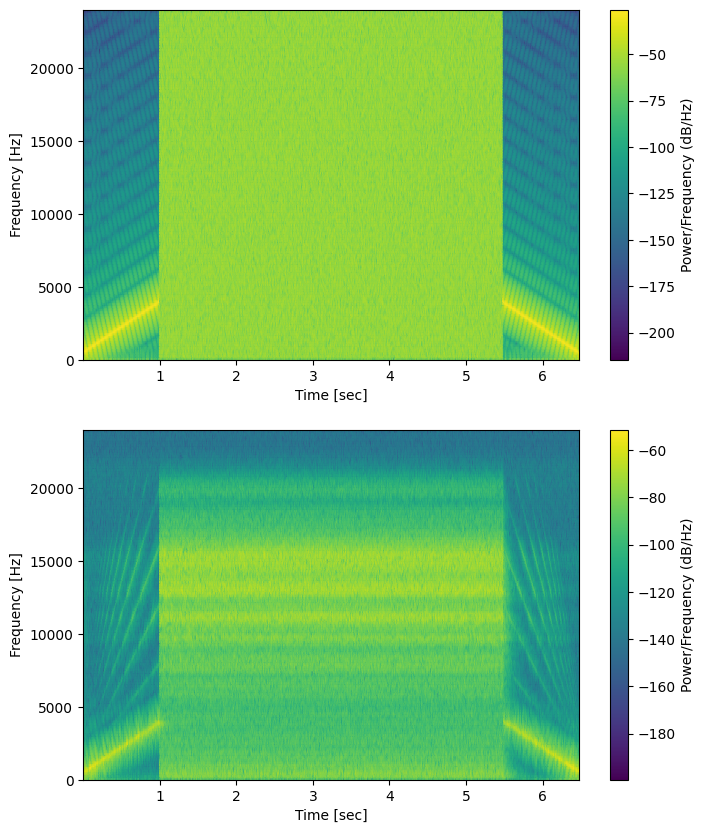

In [38]:
fig, axs = plt.subplots(2, figsize=(8, 10))
axs: tuple[plt.Axes]

for sig, ax in zip((signal, aligned_recv_signal), axs):
    f, t_spec, Sxx = scipy.signal.spectrogram(sig, FS)

    pcm = ax.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    cbar = fig.colorbar(pcm, ax=ax, label='Power/Frequency (dB/Hz)')

In [39]:
print(type(RECIEVED_DATA_BLOCKS))

<class 'int'>


In [40]:
known_qpsk_symbols = pilot.interleave_pilot_blocks([None] * RECIEVED_DATA_BLOCKS, pilot_qpsk_symbols)

In [41]:
frequency_gains = [
    None if qpsk_syms is None else
    qpsk.decode_ofdm_symbol(recv_sym, np.ones(QPSK_BLOCK_LENGTH)) / qpsk_syms
    for recv_sym, qpsk_syms in zip(recv_ofdm_symbols, known_qpsk_symbols)
]
valid_gains = [fg for fg in frequency_gains if fg is not None]
avg_gain = np.mean(valid_gains, axis=0)

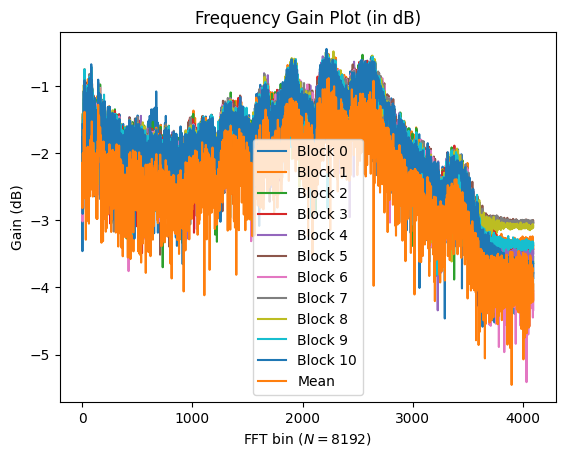

In [42]:
fig, ax = plt.subplots()
for i, block_gain in enumerate(valid_gains):
    ax.plot(np.log10(np.abs(block_gain)), label=f"Block {i}")
ax.plot(np.log10(np.abs(avg_gain)), label="Mean")
ax.set_title('Frequency Gain Plot (in dB)')
ax.set_xlabel('FFT bin ($N = 8192$)')
ax.set_ylabel('Gain (dB)')
ax.legend()

In [43]:
recv_pilot_ofdm_symbols = []
recv_data_ofdm_symbols = []

step = 1 + DATA_PER_PILOT
for i, sym in enumerate(recv_ofdm_symbols):
    if i % step == 0:
        recv_pilot_ofdm_symbols.append(sym)
    else:
        recv_data_ofdm_symbols.append(sym)
        

In [44]:
recv_data_qpsk_symbols = [qpsk.decode_ofdm_symbol(recv_sym, avg_gain) for recv_sym in recv_data_ofdm_symbols]

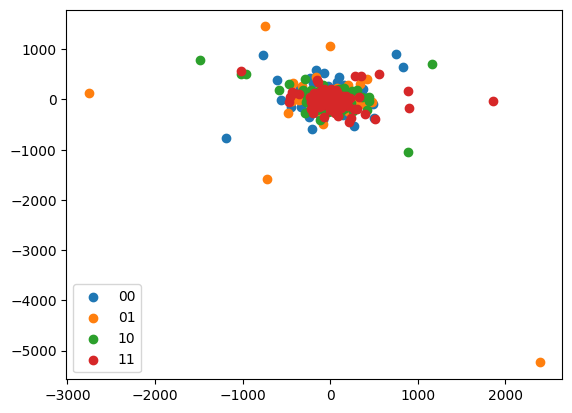

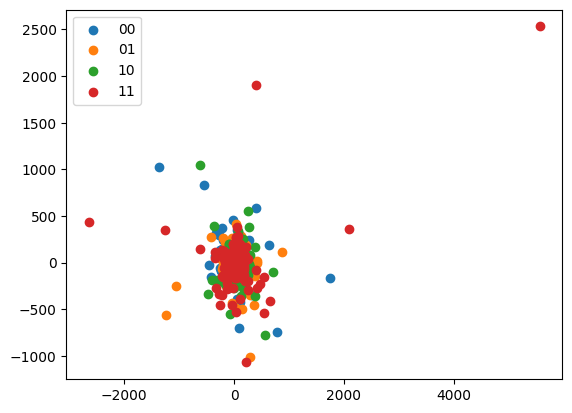

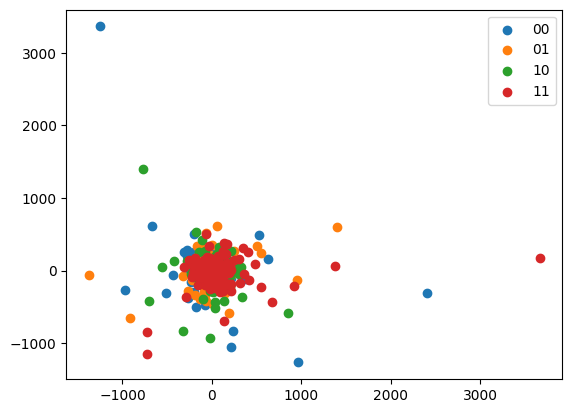

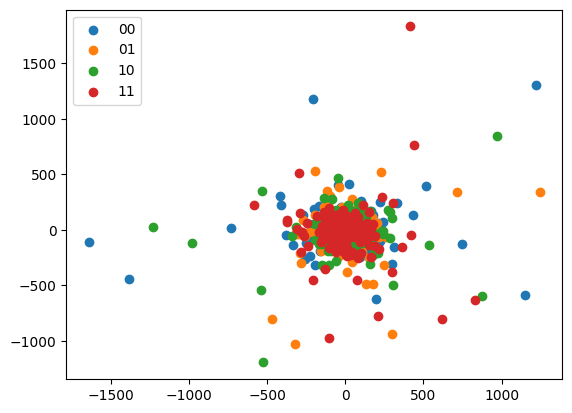

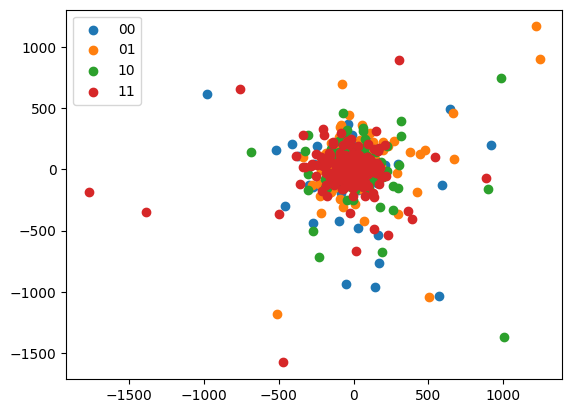

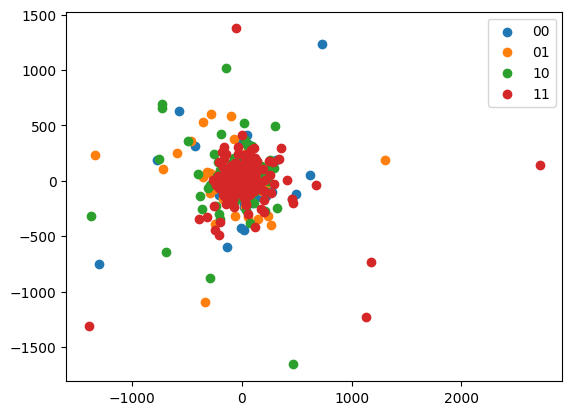

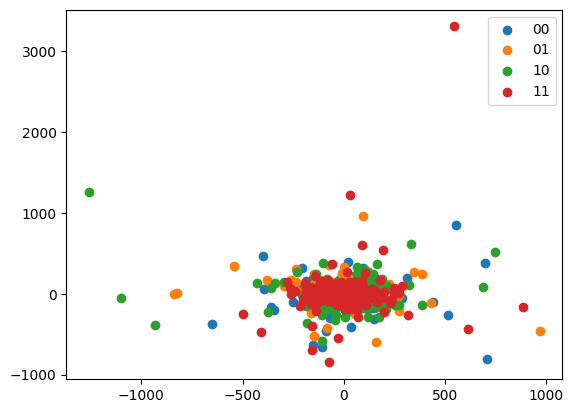

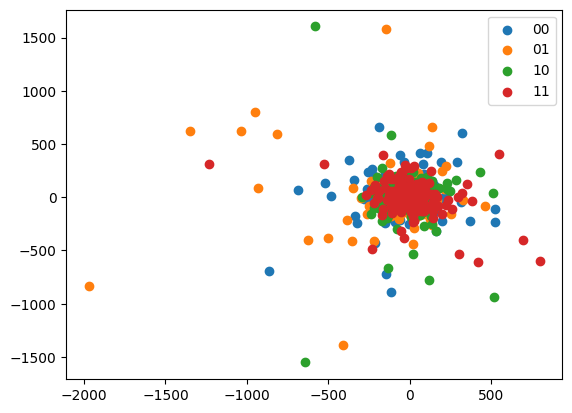

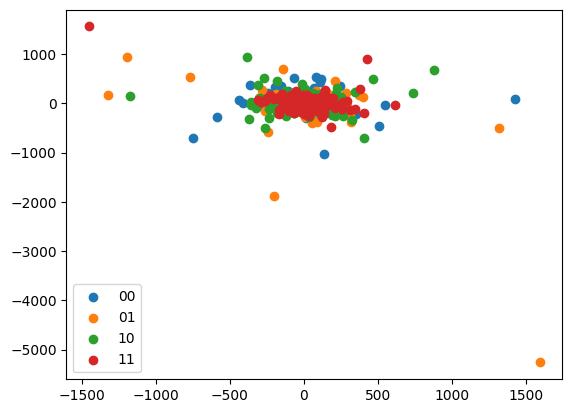

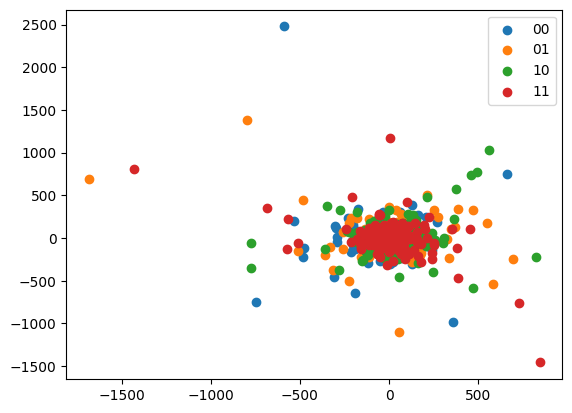

In [ ]:
for i in range(RECIEVED_DATA_BLOCKS):
    # Create boolean masks to color received symbols based on what the transmitted symbol was
    high_freq_mask = np.zeros_like(data_qpsk_symbols[i], dtype=np.bool)
    high_freq_mask[100:1000] = True
    positive_real_mask = np.real(data_qpsk_symbols[i]) > 0
    positive_imag_mask = np.imag(data_qpsk_symbols[i]) > 0
    mask_00 = positive_real_mask & positive_imag_mask & high_freq_mask
    mask_01 = (~positive_real_mask) & positive_imag_mask & high_freq_mask
    mask_11 = (~positive_real_mask) & (~positive_imag_mask) & high_freq_mask
    mask_10 = positive_real_mask & (~positive_imag_mask) & high_freq_mask

    # Plot received symbols
    fig, ax = plt.subplots()
    for mask, bits in ((mask_00, "00"), (mask_01, "01"), (mask_10, "10"), (mask_11, "11")):
        ax.scatter(np.real(recv_data_qpsk_symbols[i][mask]), np.imag(recv_data_qpsk_symbols[i][mask]), label=bits)
    ax.legend()